In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import re
os.environ['GLOG_minloglevel'] = '2'
import caffe
import math
%matplotlib inline

The below steps show how the default cifar10 models run on arm cmsis nn, and it works well generally.

In [2]:
cwd = os.path.abspath(os.curdir)

In [3]:
def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))

def Download(url, force=False):
    tgt = os.path.basename(url)
    if(os.path.exists(tgt) and force):
        RunSysCmd('rm -f %s'%(tgt))
    if(not os.path.exists(tgt)):
        RunSysCmd('wget %s'%(url))
    return tgt

def ToList(d):
    sz=1
    for s in d.shape:
        sz = sz*s
    return d.reshape(sz).tolist()

def q2f(d, Q):
    '''To convert a number from Qm.n format to floating point:
        1. Convert the number to floating point as if it were an integer, in other words remove the binary point
        2. Multiply by 2−n
    '''
    if(type(d) is list):
        D = []
        for v in d:
            D.append(float(v*math.pow(2,-Q)))
    elif(type(d) is np.ndarray):
        D = d*math.pow(2,-Q)
    else:
        D = float(d*math.pow(2,-Q))
    return D

def show(w):
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    plt.figure(figsize=(18, 3))  
    plt.subplot(121)
    plt.title('green is real, red is sort')
    plt.plot(aL,'g')
    plt.grid()
    aL.sort()
    plt.plot(aL,'r')
    plt.grid()
    plt.subplot(122)
    plt.hist(aL,100)
    plt.title('hist')
    plt.grid()
    plt.show()

def compare(a,b):
    if(type(a) is np.ndarray):
        aL = ToList(a)
    else:
        aL = list(a)
    if(type(b) is np.ndarray):
        bL = ToList(b)
    else:
        bL = list(b)
    assert(len(aL) == len(bL))
    Z = list(zip(aL,bL))
    Z.sort(key=lambda x: x[0])
    aL,bL=zip(*Z)
    plt.figure(figsize=(18, 3))
    plt.subplot(131)
    plt.plot(aL,'r')
    plt.grid()
    plt.subplot(133)
    plt.plot(bL,'g')
    plt.plot(aL,'r')
    plt.grid()
    plt.subplot(132)
    bL=list(bL)
    bL.sort()
    plt.plot(bL,'g')
    plt.grid()

In [4]:
RunSysCmd('scons')

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
LINK cifar10
scons: done building targets.



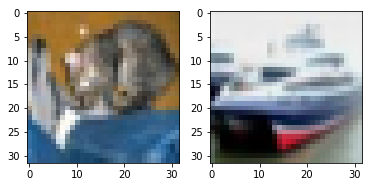

In [5]:
defaults = []
reImg = re.compile('#define IMG_DATA \{([\w\d,]+)\}')
with open('arm_nnexamples_cifar10_inputs.h') as f:
    for l in f.readlines():
        if(reImg.search(l)):
            data = eval('['+reImg.search(l).groups()[0]+']')
            data = np.asarray(data,dtype=np.uint8).reshape(32,32,3)
            defaults.append(data)
fig, axs = plt.subplots(1, len(defaults))
for i,dft in enumerate(defaults):
    axs[i].imshow(dft)

In [6]:
for i,dft in enumerate(defaults):
    data = dft
    data.tofile('img.bin')
    RunSysCmd('./cifar10 img.bin')

start execution
airplane: 0.7%
automobile: 0.0%
bird: 0.0%
cat: 98.4%
deer: 0.0%
dog: 0.0%
frog: 0.0%
horse: 0.0%
ship: 0.0%
truck: 0.0%

start execution
airplane: 0.0%
automobile: 0.0%
bird: 0.0%
cat: 0.0%
deer: 0.0%
dog: 0.0%
frog: 0.0%
horse: 0.0%
ship: 99.2%
truck: 0.0%



In [7]:
# CATs
#url = 'http://p5.so.qhimgs1.com/bdr/_240_/t011b628e47ccf9983b.jpg'
#url = 'http://p3.so.qhmsg.com/bdr/_240_/t01067394101dcd6278.jpg'
#url = 'http://p5.so.qhimgs1.com/bdr/_240_/t01425873ec4207251b.jpg'

# AIRPLANEs
#url = 'http://p0.so.qhimgs1.com/bdr/_240_/t01a45e71a8867f2354.jpg'
#url = 'http://p4.so.qhmsg.com/bdr/_240_/t01cbd2106353872279.jpg'

# DOGs
#url = 'http://p0.so.qhimgs1.com/bdr/_240_/t0180d8b6dbb9eb54b0.jpg'
#url = 'http://p5.so.qhimgs1.com/bdr/_240_/t015ac334b42ef829db.jpg'
url = 'http://p3.so.qhimgs1.com/bdr/_240_/t017f279f05b2c73b93.jpg'
img = Download(url,True)

start execution
airplane: 0.0%
automobile: 0.0%
bird: 0.0%
cat: 0.0%
deer: 0.0%
dog: 99.2%
frog: 0.0%
horse: 0.0%
ship: 0.0%
truck: 0.0%



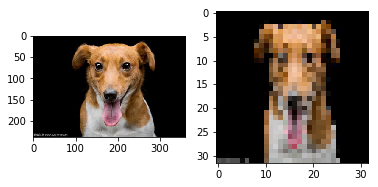

In [8]:
# ref plot: https://www.jianshu.com/p/2b2caa2cf381
im = Image.open(img)
im = im.convert('RGB')
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im)
im = im.resize((32,32))
im.save('img.png')
axs[1].imshow(im)
data = np.asarray(im)
data = data.astype(np.int8)
data.tofile('img.bin')
RunSysCmd('./cifar10 img.bin')

Now research about how the cifar10 model was quantized and run on arm cmsis nn with Q Format.

Firstly, It's much more better to follow page [cifar10 convert tools](https://github.com/ARM-software/ML-examples/tree/master/cmsisnn-cifar10) to study about how to quantize a model and generated C files.

But need to modify the models/cifar10_m7_train_test.prototxt to point to the right input data and then run below command:

```sh
cd ML-examples/cmsisnn-cifar10
python nn_quantizer.py --model models/cifar10_m7_train_test.prototxt \
  --weights models/cifar10_m7_iter_300000.caffemodel.h5 \
  --save models/cifar10_m7.pkl
python code_gen.py --model models/cifar10_m7.pkl --out_dir code/m7
```

In [9]:
m7=True
if(m7):
    model_file ='ML-examples/cmsisnn-cifar10/models/cifar10_m7_train_test.prototxt'
    weight_file='ML-examples/cmsisnn-cifar10/models/cifar10_m7_iter_300000.caffemodel.h5'
    genWT='ML-examples/cmsisnn-cifar10/code/m7/weights.h'
else:
    model_file ='ML-examples/cmsisnn-cifar10/models/cifar10_m4_train_test.prototxt'
    weight_file='ML-examples/cmsisnn-cifar10/models/cifar10_m4_iter_70000.caffemodel.h5'
    genWT='ML-examples/cmsisnn-cifar10/code/m4/weights.h'

RunSysCmd('git clone https://github.com/autoas/ML-examples.git')

inference_model = 'ML-examples/cmsisnn-cifar10/models/inference.prototxt'

Then on need to new a inference model inference.prototxt based on the cifar10_m7_train_test.prototxt by:

* 1. Replace the data layer as below:

```json
layer {
    name:"data"
    type:"Input"
    top:"data"
    input_param {shape: {dim:1 dim:3 dim:32 dim:32}}
}
```

* 2. And then remove the layer accuracy and loss, and add below softmax layer:

```json
layer {
  name: "prob"
  type: "Softmax"
  bottom: "ip1"
  top: "prob"
}
```

In [10]:
# load caffe model
caffe.set_mode_cpu()
net = caffe.Net(inference_model,weight_file,caffe.TEST)

All of the below method is not given the right prediction, I don't know why, need more research.

In [11]:
# caffe method 1
#caffe_model_file = '/home/parai/workspace/caffe/examples/cifar10/cifar10_quick.prototxt'
#caffe_weight_file = '/home/parai/workspace/caffe/examples/cifar10/cifar10_quick_iter_5000.caffemodel.h5'
caffe_model_file = inference_model
caffe_weight_file = weight_file
#caffeTestImg = '${CAFFE}/examples/images/cat.jpg'
caffeTestImg = 'img.png'
cmd = 'export CAFFE=${HOME}/workspace/caffe'
cmd += ' && export PYTHONPATH=${CAFFE}/python:$PYTHONPATH'
cmd += ' && python2 ${CAFFE}/python/classify.py --model_def %s' \
       ' --pretrained_model %s' \
       ' --center_only %s result'%(caffe_model_file, caffe_weight_file, caffeTestImg)
RunSysCmd(cmd)

CIFAR10_LABELS_LIST = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]
r = np.load('result.npy').tolist()[0]
R = list(zip(CIFAR10_LABELS_LIST,r))
print(R)

CPU mode
Loading file: img.png
Classifying 1 inputs.
Done in 0.06 s.
Saving results into result

[('airplane', 0.26359468698501587), ('automobile', 0.0012160834157839417), ('bird', 0.13260996341705322), ('cat', 0.3096497356891632), ('deer', 0.03655122220516205), ('dog', 0.00904895830899477), ('frog', 0.0213351808488369), ('horse', 0.0060678934678435326), ('ship', 0.21287165582180023), ('truck', 0.007054596208035946)]


In [12]:
# caffe method 2
if(1):
    im = Image.open(img)
    im = im.convert('RGB')
    im = im.resize((32,32))
else:
    im = defaults[0]
im = np.asarray(im)
#fig, axs = plt.subplots(1, 3)
#axs[0].imshow(im)
#print(im[2][:10])
im = im - (125,123,114)
#print(im[2][:10])
im = np.asarray(im.transpose(2,0,1))
#axs[1].imshow(im.transpose(1,2,0))
net.blobs['data'].data[...] = im.astype(np.float32)
#axs[2].imshow(im.transpose(1,2,0)+(125,123,114))
out = net.forward()
print(out)
# save output of each layer
RunSysCmd('mkdir -p caffe_out2 caffe_out3 out')
for name,blob in net.blobs.items():
    d = blob.data
    if(len(d.shape)==4):
        d = blob.data.transpose((0,2,3,1))
    d.tofile('caffe_out2/%s.raw'%(name))
    print('layer %s shape: %s'%(name, blob.data.shape))

{'prob': array([[1.9553248e-09, 7.0088383e-08, 1.0928374e-04, 7.1809114e-07,
        1.0836728e-05, 9.9987793e-01, 2.1509886e-07, 3.5570571e-07,
        6.1385364e-08, 4.9647923e-07]], dtype=float32)}

layer data shape: (1, 3, 32, 32)
layer conv1 shape: (1, 32, 32, 32)
layer pool1 shape: (1, 32, 16, 16)
layer conv2 shape: (1, 32, 16, 16)
layer pool2 shape: (1, 32, 8, 8)
layer conv3 shape: (1, 64, 8, 8)
layer pool3 shape: (1, 64, 4, 4)
layer ip1 shape: (1, 10)
layer prob shape: (1, 10)


In [13]:
# caffe method 3
# run inference, https://www.zhihu.com/question/38107945
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
# change dimensition from HWC to CHW
transformer.set_transpose('data', (2,0,1))
# subtract mean
mean = np.asarray((125,123,114)) # RGB
transformer.set_mean('data', mean)
# scale to range 0-255
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0)) # if using RGB instead of BGR
im=caffe.io.load_image(img)
#fig, axs = plt.subplots(1, 2)
#axs[0].imshow(im)
im = transformer.preprocess('data',im)
net.blobs['data'].data[...] = im
out = net.forward()
#axs[1].imshow(im.transpose(1,2,0))
print(out)

/opt/anaconda3/envs/ai/lib/python3.6/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/opt/anaconda3/envs/ai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/anaconda3/envs/ai/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


{'prob': array([[4.8989467e-08, 6.7161642e-07, 5.4634225e-02, 1.9412562e-06,
        3.7302645e-08, 9.3889964e-01, 3.8893833e-07, 8.3338586e-04,
        2.2622719e-06, 5.6275041e-03]], dtype=float32)}


In [14]:
# load quantized weights
weights = {}
reWT = re.compile('#define\s+(\w+)\s+\{([-\w\d,]+)\}')
with open(genWT) as f:
    for l in f.readlines():
        if(reWT.search(l)):
            grp = reWT.search(l).groups()
            name = grp[0]
            data = eval('['+grp[1]+']')
            weights[name] = data

In [15]:
for name, p in net.params.items():
    for i,blob in enumerate(p):
        d = blob.data
        print('%s weiths[%s]: max=%s, min=%s, shape=%s'%(name,i,d.max(),d.min(),d.shape))

conv1 weiths[0]: max=0.3696457, min=-0.5306129, shape=(32, 3, 5, 5)
conv1 weiths[1]: max=0.011151921, min=-0.009737949, shape=(32,)
conv2 weiths[0]: max=0.29377562, min=-0.24854313, shape=(32, 32, 5, 5)
conv2 weiths[1]: max=0.005944243, min=-0.005435754, shape=(32,)
conv3 weiths[0]: max=0.17977287, min=-0.16663472, shape=(64, 32, 5, 5)
conv3 weiths[1]: max=0.0057027047, min=-0.0063875853, shape=(64,)
ip1 weiths[0]: max=0.03582655, min=-0.013514213, shape=(10, 1024)
ip1 weiths[1]: max=2.5444574, min=-2.1726463, shape=(10,)


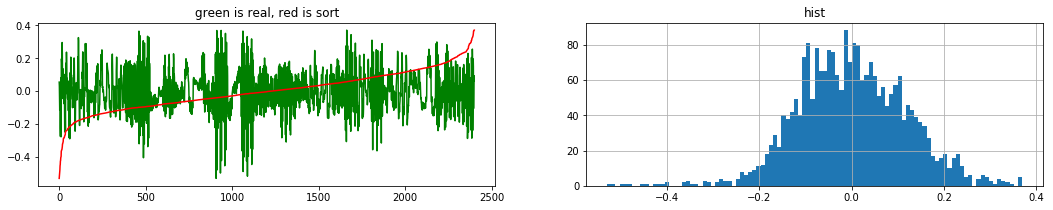

In [16]:
show(net.params['conv1'][0].data)

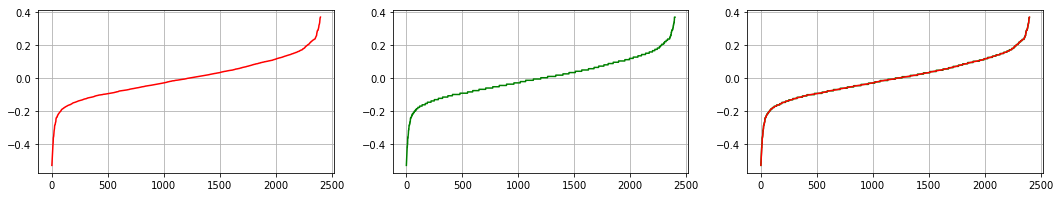

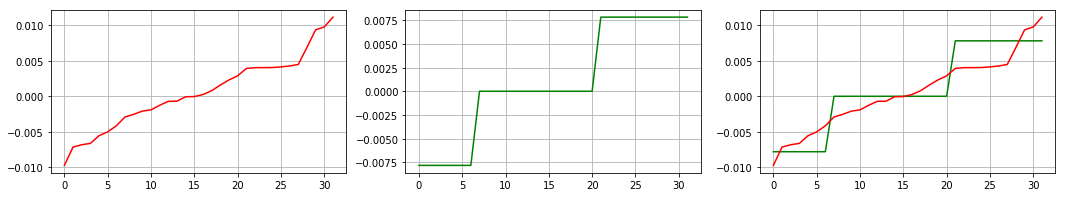

In [17]:
CONV1_WT = q2f(weights['CONV1_WT'],7)
CONV1_BIAS = q2f(weights['CONV1_BIAS'],7)
compare(net.params['conv1'][0].data.transpose(0,2,3,1), CONV1_WT)
compare(net.params['conv1'][1].data, CONV1_BIAS)

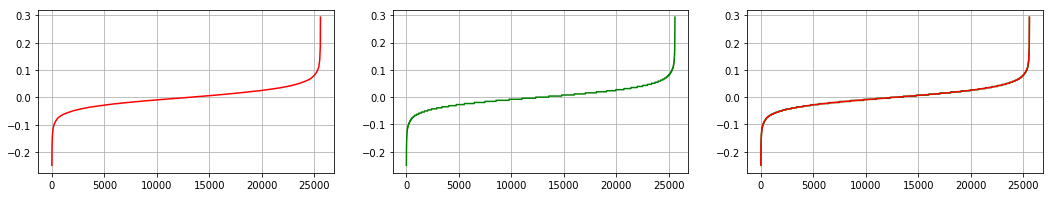

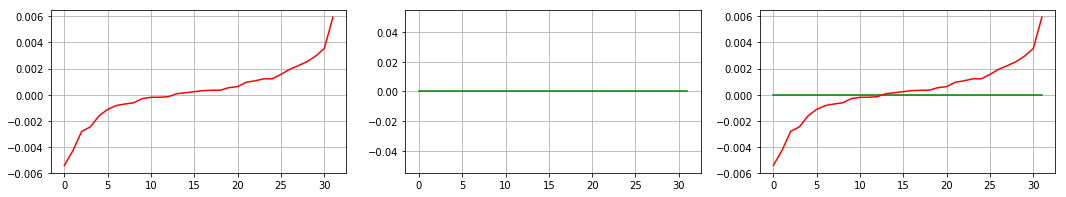

In [18]:
CONV2_WT = q2f(weights['CONV2_WT'],8)
CONV2_BIAS = q2f(weights['CONV2_BIAS'],8)
compare(net.params['conv2'][0].data.transpose(0,2,3,1), CONV2_WT)
compare(net.params['conv2'][1].data, CONV2_BIAS)

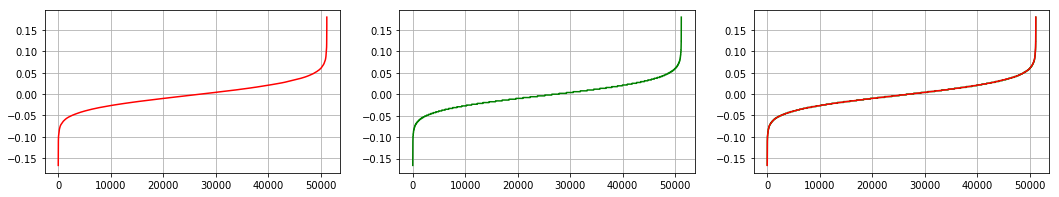

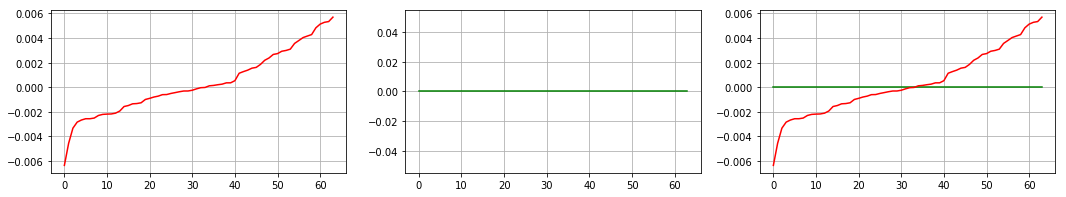

In [19]:
CONV3_WT = q2f(weights['CONV3_WT'],9)
CONV3_BIAS = q2f(weights['CONV3_BIAS'],8)
compare(net.params['conv3'][0].data.transpose(0,2,3,1), CONV3_WT)
compare(net.params['conv3'][1].data, CONV3_BIAS)

In [20]:
RunSysCmd('scons --m7')

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
LINK cifar10
scons: done building targets.



In [21]:
RunSysCmd('./cifar10 img.bin')

airplane: 0.0%
automobile: 0.0%
bird: 99.2%
cat: 0.0%
deer: 0.0%
dog: 0.0%
frog: 0.0%
horse: 0.0%
ship: 0.0%
truck: 0.0%



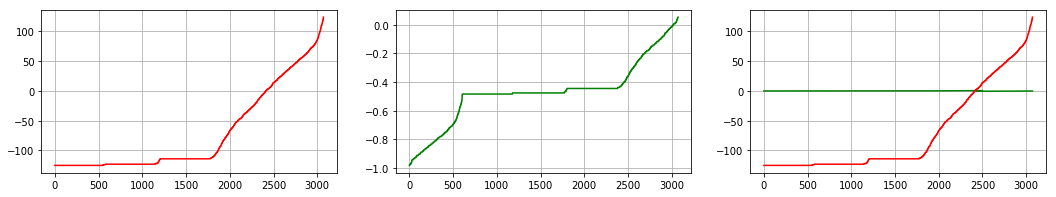

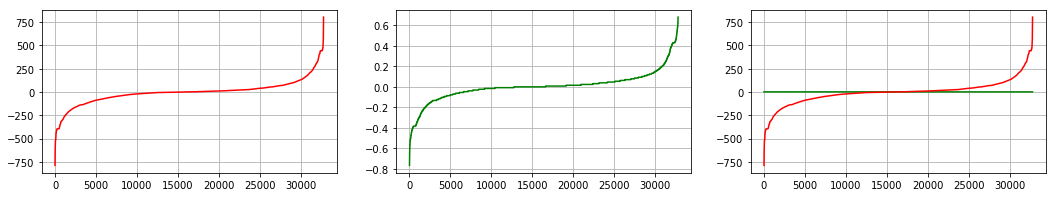

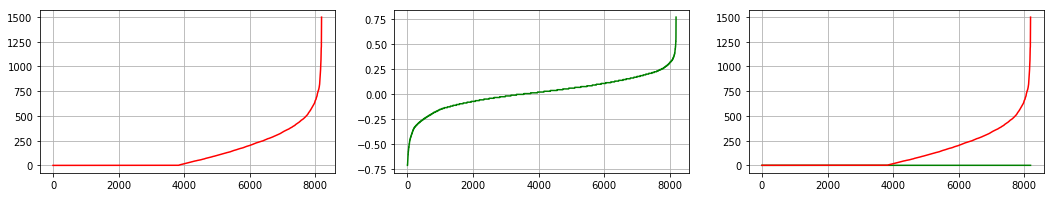

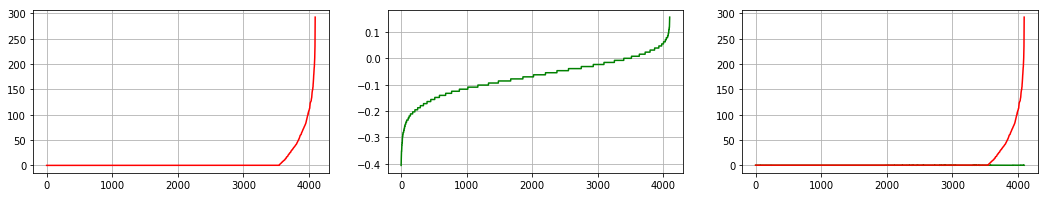

In [22]:
compare( np.fromfile('caffe_out2/data.raw', dtype=np.float32), 
    q2f(np.fromfile('out/data.raw', dtype=np.int8),7) )
compare( np.fromfile('caffe_out2/conv1.raw', dtype=np.float32), 
    q2f(np.fromfile('out/conv1.raw', dtype=np.int8),7) )
compare( np.fromfile('caffe_out2/conv2.raw', dtype=np.float32), 
    q2f(np.fromfile('out/conv2.raw', dtype=np.int8),7) )
compare( np.fromfile('caffe_out2/conv3.raw', dtype=np.float32), 
    q2f(np.fromfile('out/conv3.raw', dtype=np.int8),7) )

study of the cifar10 traning data and test data, try to know how data was feed to caffe

In [23]:
import lmdb

In [24]:
#env = lmdb.open('/home/parai/workspace/caffe/examples/cifar10/cifar10_train_lmdb', readonly=True)
env = lmdb.open('/home/parai/workspace/caffe/examples/cifar10/cifar10_test_lmdb', readonly=True)

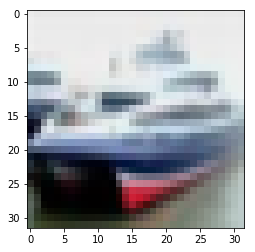

In [25]:
RunSysCmd('mkdir -p testimg')
with env.begin() as txn:
    cursor = txn.cursor()
    for i, (key, value) in enumerate(cursor):
        if(i!=1):continue
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        flat_x = np.frombuffer(datum.data, dtype=np.uint8)
        x = flat_x.reshape(datum.channels, datum.height, datum.width)
        y = datum.label
        #Image.fromarray(x.transpose(1,2,0)).save('testimg/%s_%s.png'%(CIFAR10_LABELS_LIST[int(y)],i))
        plt.imshow(x.transpose(1,2,0))
        break

In [26]:
inference_model = 'ML-examples/cmsisnn-cifar10/models/cifar10_m7_train_test.prototxt'
weight_file='ML-examples/cmsisnn-cifar10/models/cifar10_m7_iter_300000.caffemodel.h5'
caffe.set_mode_cpu()
net = caffe.Net(inference_model,weight_file,caffe.TEST)
out = net.forward()
print(out)

{'accuracy': array(0.78, dtype=float32), 'loss': array(0.6550547, dtype=float32)}


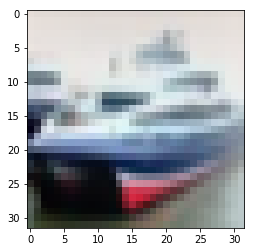

In [27]:
im = net.blobs['data'].data.transpose(0,2,3,1)[1]
im = im + (125, 123, 114) # RGB
im = im.astype(np.uint8)
plt.imshow(im)

so from the TEST lmdb, it's clear that the input data will be with range about float32(-128, 128), so this will be definitely different with arm CMSIS NN, arm CMSIS NN request range about(-1, 1), so the TRANING lmdb and TEST lmdb need to be modified by divided each input by 128 maybe, and then get the model retrained, or add a scale layer to scale the input data to range (-1, 1).

https://stackoverflow.com/questions/37410996/scale-layer-in-caffe

```json
layer {
  name: "sc"
  type: "Scale"
  bottom: "data"
  top: "sc"
  param {
    lr_mult: 0
    decay_mult: 0
  }
  param {
    lr_mult: 0
    decay_mult: 0
  }
  scale_param {
    filler { value: 0.00392156862745098 }
    bias_term: true
    bias_filler { value: 0 }
  }
}
```